In [ ]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os
from numpy.lib.recfunctions import append_fields
import scipy.stats

import healpy

import matplotlib.pyplot as plt
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap
from sys_functions import *

#csfd = healpy.fitsfunc.read_map('/fs/scratch/PCON0008/warner785/bwarner/csfd_ebv.fits')
#maglim = esutil.io.read('/fs/project/PCON0008/des_y3/maglim/mag_lim_lens_sample_combined_jointmask_sample.fits.gz')
#mask = esutil.io.read('/fs/project/PCON0008/des_y3/maglim/mask/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz')
#weights = esutil.io.read('/fs/project/PCON0008/des_y3/maglim/weight_maps/w_map_bin2_nside4096_nbins1d_10_2sig_v2.0.fits.gz')
#dmass_spt = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')

None

XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                 4096 / length of dimension 1
NAXIS2  =                49152 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                    1 / number of table fields
TTYPE1  = 'T'                  / 
TFORM1  = '1024E'              / 
PIXTYPE = 'HEALPIX'            / HEALPIX pixelisation
ORDERING= 'RING'               / Pixel ordering scheme, either RING or NESTED
EXTNAME = 'xtension'           / name of this binary table extension
NSIDE   =                 2048 / Resolution parameter of HEALPIX
FIRSTPIX=                    0 / First pixel # (0 based)
LASTPIX =             50331647 / Last pixel # (0 based)
INDXSCHM= 'IMPLICIT'           / Indexing: IMPLICIT or EXPLICIT
OBJECT  = 'FULLSKY'            / Sky cover

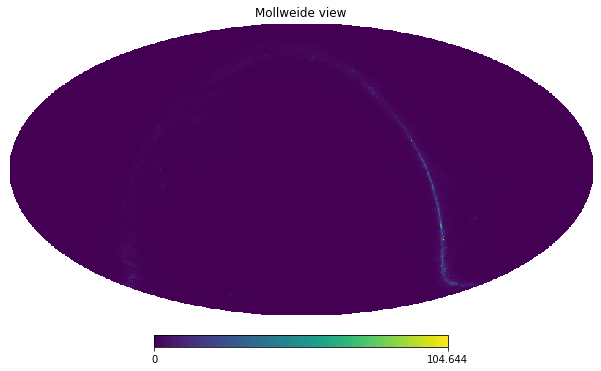

In [45]:
print(csfd.dtype.names)
f = fitsio.FITS('/fs/scratch/PCON0008/warner785/bwarner/csfd_ebv.fits')
h = f[-1].read_header()
print(h)

print(csfd.shape)
#flat = rot_csfd.flatten()
#print(flat.shape)
print(hp.visufunc.mollview(rot_csfd))
esutil.io.write('/fs/scratch/PCON0008/warner785/bwarner/csfd.fits', rot_csfd, overwrite=True)

In [ ]:
imap =esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/csfd.fits')
print(imap)

In [57]:
#signal = np.array(sysMap1)
#print(signal)

[0.2578817  0.25334203 0.24901828 ... 0.1817264  0.17679744 0.18455049]


In [ ]:
#csfdHp = np.full(hp.nside2npix(2048), hp.UNSEEN)
csfd_upgrade = hp.pixelfunc.ud_grade(imap, 4096, pess=False, order_in='RING', order_out=None, power=None, dtype=None)

In [26]:
sysMap = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/csfd.fits')
pixels = np.zeros(sysMap.size)
for x in range(pixels.size):
    if x>0:
        pixels[x]=pixels[x-1]+1
signal = np.array(sysMap)
sysMap = np.zeros( len(pixels), dtype=[('PIXEL','int'), ('SIGNAL','float')])
sysMap['SIGNAL'] = signal
sysMap['PIXEL'] = pixels

In [27]:
RA, DEC = hp.pix2ang(2048, sysMap['PIXEL'], lonlat=True)

In [30]:
sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)

In [29]:
print(np.min(DEC))

-89.97715732012509


In [17]:
print(np.any(sysMap['RA']>295))

True


In [44]:
# for RA conversion
def rewrap(x):
    new = []
    for i in range(len(x)):
        ra = x[i] + 180
        new.append(ra)
    return new

new = rewrap(RAnew)
print(new)

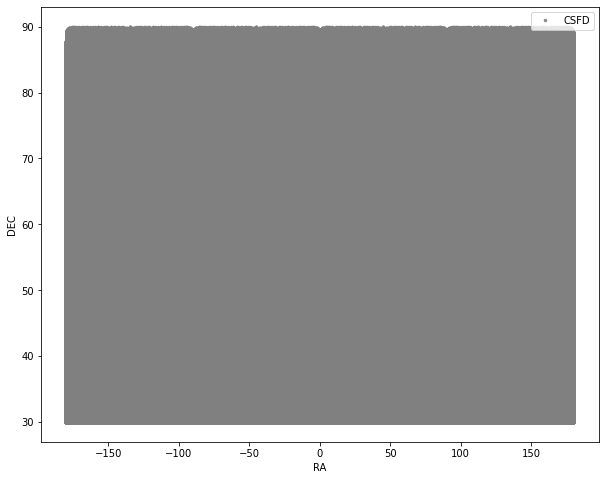

In [10]:
spatialcheck([sysMap], 
             label = ['CSFD'], convert = None, ratag='RA',dectag='DEC')

In [31]:
sysMap = keepGoodRegion(sysMap)
print(sysMap)
# plot cut region - - each step
#upgrade map before loading

[(22745651, 0.02684195, 24.74121094,   5.51052757)
 (22745652, 0.02624961, 24.78515625,   5.51052757)
 (22745653, 0.02667446, 24.82910156,   5.51052757) ...
 (48471768, 0.07658502, 59.79771784, -67.8418301 )
 (48471769, 0.07057153, 59.89107884, -67.8418301 )
 (48471770, 0.06626338, 59.98443983, -67.8418301 )]


In [32]:
mask_spt = (sysMap['RA']>295)&(sysMap['RA']<360)|(sysMap['RA']<105)
mask_spt = mask_spt & (sysMap['DEC']>-68) & (sysMap['DEC']<-10)
sysMap = sysMap[mask_spt]
print(sysMap)

[(29536786, 0.03109795, 23.31298828, -10.01046944)
 (29536787, 0.03070482, 23.35693359, -10.01046944)
 (29536788, 0.03082674, 23.40087891, -10.01046944) ...
 (48471768, 0.07658502, 59.79771784, -67.8418301 )
 (48471769, 0.07057153, 59.89107884, -67.8418301 )
 (48471770, 0.06626338, 59.98443983, -67.8418301 )]


In [33]:
esutil.io.write('/fs/scratch/PCON0008/warner785/bwarner/csfd_spt.fits', sysMap, overwrite=True)

In [9]:
sysMap = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/SPmaps_csfd/SFD98.fits')
print(sysMap)

OSError: No extensions have data

In [5]:
RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)

In [6]:
print(np.max(RA), np.min(RA))

359.989013671875 0.0


In [59]:
#map_path = '/fs/scratch/PCON0008/warner785/bwarner/SPmaps_csfd/'
sysMap = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/SPmaps_csfd/SFD98.fits')
print(sysMap)

OSError: No extensions have data

In [37]:
import healpy
data = csfd
npix = 50331648
nside = 2048
rot_csfd = gal2eq(data)

In [36]:
import numpy as np
import healpy as hp
import scipy.interpolate as interp
import healpix_util as hu
import matplotlib.pyplot as plt
import time
import random
import fitsio as fio
import os
import treecorr
import copy
import pdb
import sys
import scipy.linalg as linalg
import pylab
import astropy.coordinates

def gal2eq(data,map_coord='G', new_coord='C',inplace=False, usemask = False):
	"""
	converts a map from galaxtic to celestial coordinates 
	can be used for the planck extinction map
	"""
	start = time.time()
	npix = 50331648
	nside = 2048

	theta,phi = hp.pix2ang(nside,np.arange(npix)) #angles of our celestial map (what we want)
	theta2,phi2 = hp.rotator.Rotator(coord=[new_coord,map_coord])(theta,phi) #the corresponding angle in gal coords (what we have)
	
	if usemask == False:
		#this line would only work on an unmasked map
		new = hp.pixelfunc.get_interp_val(data,theta2,phi2)
	else:
		#these lines should work for a masked map
		nn_pix, nn_weight = hp.pixelfunc.get_interp_weights(nside, theta = theta2, phi = phi2)
		for i in xrange(4): #iterate over the 4 nearest neighbours
			nn_weight[i][ mask[nn_pix[i]] ] = 0.

		#The pixels with all 4 nearest neighbours masked (==0 in nn_weights)
		all_nn_masked = np.product(~nn_weight.astype('bool'), axis=0).astype('bool')

		data_good_pix   = np.array([ self.data[nn_pix][i][~all_nn_masked] for i in xrange(4)])
		weight_good_pix = np.array([ nn_weight[i][~all_nn_masked] for i in xrange(4)])

		new = np.ones(self.npix)*hp.UNSEEN
		new[~all_nn_masked] = np.average(data_good_pix, weights= weight_good_pix , axis=0)


	if inplace == True:
		data = new
		mask = np.zeros(len(new)).astype('bool')
		fracdet = np.ones(len(new))
		finish = time.time()
		print ('gal2eq took {0}s'.format(finish-start))
		return
	else:
		return new

In [22]:
print(star.dtype.names)
print(ex.dtype.names)
f = fitsio.FITS('/fs/scratch/PCON0008/warner785/bwarner/y3_stellar_density_4096_ring_jointmask_v2.2.fits.gz')
h = f[-1].read_header()
print(h)

('I',)
('PIXEL', 'SIGNAL')

XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                    8 / width of table in bytes
NAXIS2  =            201326592 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                    1 / number of fields in each row
TTYPE1  = 'I'                  / label for field   1
TFORM1  = 'D'                  / data format of field: 8-byte DOUBLE


In [20]:
print(star.shape)
flat = star['I'].flatten()
print(flat.shape)
print(hp.visufunc.mollview(ex))

#unseen = flat[flat != hp.UNSEEN]
#print(unseen[unseen != 0].size)

(201326592,)
(201326592,)


TypeError: bad number of pixels

In [2]:
print(maglim.dtype.names) #
print(mask.dtype.names)
#print(weights.dtype.names)
nside = 4096
theta, phi = hp.pixelfunc.pix2ang(nside, mask['HPIX'], nest=False, lonlat=False)


('DNF_ZMEAN_SOF', 'weight', 'DNF_ZMC_SOF', 'DNF_ZSIGMA_SOF', 'RA', 'COADD_OBJECT_ID', 'DEC')
('HPIX', 'FRACGOOD')


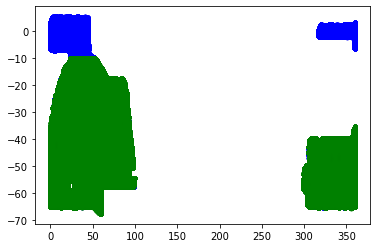

In [5]:
fig, ax = plt.subplots()
ax.plot( maglim['RA'], maglim['DEC'], "b.")
ax.plot( dmass_spt['RA'], dmass_spt['DEC'], "g.")